In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Embedding
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle
import os
import pandas

Using TensorFlow backend.


In [2]:
def normalize(df):
    norm_df = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    #df = df.drop(['date','adj_close'],axis=1)
    for col in norm_df.columns: 
        norm_df[col] = min_max_scaler.fit_transform(norm_df[col].values.reshape(-1,1))
    return norm_df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [17]:
def genInputTrain(df, pastDay=30, futureDay=5,feature='close',profit=0.03,drop=False):
    X_train = []
    for i in range(df.shape[0]-futureDay-pastDay):
        if drop:
            X_train.append(np.array(df.drop(['open','adj_close','close','high','low'],axis=1).iloc[i:i+pastDay]))
        else:
            X_train.append(np.array(df.iloc[i:i+pastDay]))
        
    return np.array(X_train)

def genOutputTrain(df,pastDay=30, futureDay=5,feature='close',profit=0.03):
    Y_train = []
    for i in range(df.shape[0]-futureDay-pastDay):
        #high_close = max(df.iloc[i+pastDay+1:i+pastDay+futureDay][feature])
        ave_close = np.mean(np.array(df.iloc[i+pastDay:i+pastDay+futureDay][feature]))
        #sub_y = (high_close-df.iloc[i+pastDay][feature])/df.iloc[i+pastDay][feature]
        sub_y = (ave_close-df.iloc[i+pastDay][feature])/df.iloc[i+pastDay][feature]
        Y_train.append(np.array([float(sub_y>profit)]))
        
    return np.array(Y_train)

def genInputTest(df, pastDay=30, feature='close',profit=0.03,drop=False):
    X_train = []
    for i in range(df.shape[0]-pastDay):
        if drop:
            X_train.append(np.array(df.drop(['open','adj_close','close','high','low'],axis=1).iloc[i:i+pastDay]))
        else:
            X_train.append(np.array(df.iloc[i:i+pastDay]))
        
    return np.array(X_train)

In [24]:
def buildModel(shape):
    print ('Creating model...')
    model = Sequential()
    #model.add(Embedding(input_dim = shape[2], output_dim = 50, input_length = shape[1]))
    model.add(LSTM(2*shape[2], activation='sigmoid', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(2*shape[2], activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model
def buildModel2(shape):
    model = Sequential()
    model.add(LSTM(units = 256,  input_shape = (shape[1], shape[2])))
    '''
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    '''
   
    model.add(Dense(units = 1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def buildModel3(shape):
    model = Sequential()
    model.add(LSTM(units = 64,  input_shape = (shape[1], shape[2]),return_sequences = True))
    model.add(Dense(units = 32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units = 32))
    model.add(Dense(units = 16, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dropout(0.5))
    #model.add(LSTM(units = 256, activation='sigmoid'))
    #model.add(Dropout(0.5))
    #model.add(LSTM(units = 32, return_sequences = True))
    #model.add(Dropout(0.5))
    #model.add(LSTM(units = 64))
    '''
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    '''
   
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    #model.compile(loss="mse", optimizer="adam")
    model.compile(loss='mean_absolute_error',optimizer="adam")
    model.summary()
    return model

In [29]:
def plot_stock(actual):
    plt.plot(actual, color='blue', label='actual')
    plt.legend(loc='best')
    plt.show()
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [6]:
def accuracy(df,model,past=30,future=5,profit=0.03,threshold=0.5,drop=False):

    Y_test=genOutputTrain(df, past,future,profit=profit)
    df_norm=normalize(df)
    X_test=genInputTrain(df_norm, past,future,drop=drop)
    result = model.predict(X_test)
    #print(Y_test[-10:])
    #print(result[-10:])
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    #print(Y_train)
    for i in range(len(result)):
        if Y_test[i,0] >0.5  and result[i]>=threshold:
            TP += 1
        elif Y_test[i,0] <0.5 and result[i]>=threshold:
            FP += 1
        elif Y_test[i,0] <0.5 and result[i]<threshold:
            TN += 1
        else:
            FN += 1
    print(f'TP:{TP}',f'FP:{FP}',f'TN:{TN}',f'FN:{FN}')
    print(TP/(TP+FP))
    print('')
            
            

    

In [7]:
def save_model(model,path):
    model.save(path)
def load_model(path):
    load_model(path)

In [25]:
#with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
#    df = pickle.load(f).iloc[:-60]
all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        print(train_data)
        
        sub_df=pickle.load(f)#.iloc[:-60]
        #print((sub_df.columns))
        #sub_df.replace([np.inf, -np.inf], np.nan,inplace=True)
        #print(sub_df.isna().sum())
        all_df.append(sub_df)

df = pd.concat(all_df,axis=0, ignore_index=True)

past = 30
future = 3
Y_train=genOutputTrain(df, past,future,profit=0.01)
df_norm=normalize(df)
X_train=genInputTrain(df_norm, past,future,drop=True)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.33)

1203.pickle
1217.pickle
2885.pickle
1218.pickle
2609.pickle
2498.pickle
2881.pickle
3034.pickle
2353.pickle
2449.pickle
1444.pickle
2308.pickle
2412.pickle
1216.pickle
3045.pickle
3008.pickle
2884.pickle
2504.pickle
1301.pickle
2344.pickle
3443.pickle
2505.pickle
2454.pickle
2330.pickle
1201.pickle
2618.pickle
2603.pickle
1707.pickle
2303.pickle
2201.pickle
2610.pickle
2889.pickle
1215.pickle
2891.pickle
2368.pickle
2892.pickle
2103.pickle
0050.pickle
1734.pickle
2337.pickle
2886.pickle


Epoch 1/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.5007 - accuracy: 0.8086 - val_loss: 0.4826 - val_accuracy: 0.8106
Epoch 2/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.4860 - accuracy: 0.8094 - val_loss: 0.4740 - val_accuracy: 0.8106
Epoch 3/1000
825/825 [==============================] - 24s 28ms/step - loss: 0.4790 - accuracy: 0.8094 - val_loss: 0.4701 - val_accuracy: 0.8106
Epoch 4/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.4756 - accuracy: 0.8094 - val_loss: 0.4731 - val_accuracy: 0.8106
Epoch 5/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.4735 - accuracy: 0.8094 - val_loss: 0.4685 - val_accuracy: 0.8106
Epoch 6/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.4720 - accuracy: 0.8094 - val_loss: 0.4675 - val_accuracy: 0.8106
Epoch 7/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.4707 - accuracy: 0.8093 - val_loss: 0.4658 -

Epoch 57/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.4332 - accuracy: 0.8178 - val_loss: 0.4515 - val_accuracy: 0.8108
Epoch 58/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.4317 - accuracy: 0.8177 - val_loss: 0.4479 - val_accuracy: 0.8141
Epoch 59/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.4304 - accuracy: 0.8186 - val_loss: 0.4485 - val_accuracy: 0.8138
Epoch 60/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.4295 - accuracy: 0.8188 - val_loss: 0.4490 - val_accuracy: 0.8129
Epoch 61/1000
825/825 [==============================] - 24s 28ms/step - loss: 0.4289 - accuracy: 0.8186 - val_loss: 0.4467 - val_accuracy: 0.8137
Epoch 62/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.4274 - accuracy: 0.8196 - val_loss: 0.4483 - val_accuracy: 0.8143
Epoch 63/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.4270 - accuracy: 0.8200 - val_loss: 0

825/825 [==============================] - 24s 29ms/step - loss: 0.3848 - accuracy: 0.8369 - val_loss: 0.4607 - val_accuracy: 0.8109
Epoch 113/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3850 - accuracy: 0.8379 - val_loss: 0.4644 - val_accuracy: 0.8084
Epoch 114/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3834 - accuracy: 0.8377 - val_loss: 0.4597 - val_accuracy: 0.8126
Epoch 115/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.3837 - accuracy: 0.8384 - val_loss: 0.4587 - val_accuracy: 0.8111
Epoch 116/1000
825/825 [==============================] - 23s 28ms/step - loss: 0.3832 - accuracy: 0.8386 - val_loss: 0.4620 - val_accuracy: 0.8096
Epoch 117/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3826 - accuracy: 0.8389 - val_loss: 0.4646 - val_accuracy: 0.8129
Epoch 118/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3808 - accuracy: 0.8395 - val_loss: 0.4640 - 

825/825 [==============================] - 23s 28ms/step - loss: 0.3553 - accuracy: 0.8508 - val_loss: 0.4984 - val_accuracy: 0.8081
Epoch 168/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3556 - accuracy: 0.8497 - val_loss: 0.4830 - val_accuracy: 0.8068
Epoch 169/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3520 - accuracy: 0.8510 - val_loss: 0.4968 - val_accuracy: 0.8088
Epoch 170/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3531 - accuracy: 0.8507 - val_loss: 0.4805 - val_accuracy: 0.8108
Epoch 171/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3524 - accuracy: 0.8515 - val_loss: 0.4962 - val_accuracy: 0.8097
Epoch 172/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3532 - accuracy: 0.8512 - val_loss: 0.4950 - val_accuracy: 0.8094
Epoch 173/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3525 - accuracy: 0.8510 - val_loss: 0.4934 - 

825/825 [==============================] - 26s 31ms/step - loss: 0.3317 - accuracy: 0.8600 - val_loss: 0.5260 - val_accuracy: 0.8048
Epoch 223/1000
825/825 [==============================] - 26s 31ms/step - loss: 0.3322 - accuracy: 0.8608 - val_loss: 0.5122 - val_accuracy: 0.8045
Epoch 224/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3326 - accuracy: 0.8595 - val_loss: 0.5167 - val_accuracy: 0.8060
Epoch 225/1000
825/825 [==============================] - 24s 29ms/step - loss: 0.3315 - accuracy: 0.8609 - val_loss: 0.5325 - val_accuracy: 0.8033
Epoch 226/1000
825/825 [==============================] - 31s 38ms/step - loss: 0.3320 - accuracy: 0.8603 - val_loss: 0.5282 - val_accuracy: 0.8009
Epoch 227/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3320 - accuracy: 0.8607 - val_loss: 0.5249 - val_accuracy: 0.8070
Epoch 228/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3319 - accuracy: 0.8611 - val_loss: 0.5067 - 

825/825 [==============================] - 34s 41ms/step - loss: 0.3176 - accuracy: 0.8674 - val_loss: 0.5643 - val_accuracy: 0.8017
Epoch 278/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3200 - accuracy: 0.8652 - val_loss: 0.5437 - val_accuracy: 0.8050
Epoch 279/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3165 - accuracy: 0.8667 - val_loss: 0.5589 - val_accuracy: 0.8010
Epoch 280/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3180 - accuracy: 0.8674 - val_loss: 0.5351 - val_accuracy: 0.8026
Epoch 281/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3175 - accuracy: 0.8671 - val_loss: 0.5426 - val_accuracy: 0.8051
Epoch 282/1000
825/825 [==============================] - 36s 44ms/step - loss: 0.3181 - accuracy: 0.8666 - val_loss: 0.5434 - val_accuracy: 0.8050
Epoch 283/1000
825/825 [==============================] - 34s 41ms/step - loss: 0.3152 - accuracy: 0.8683 - val_loss: 0.5436 - 

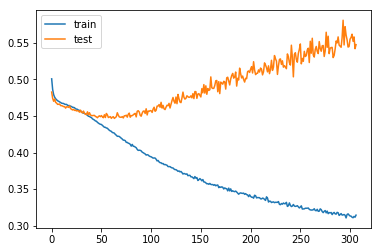

In [26]:
model = buildModel3(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history=model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])
training_result(history)

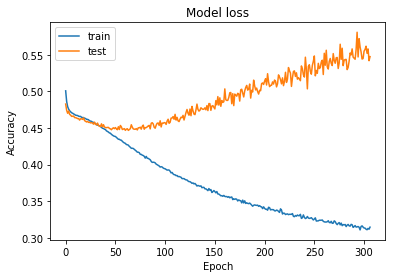

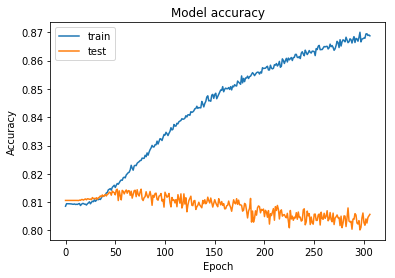

In [30]:
training_result(history)

In [32]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
#print(df.head())
df_norm=normalize(df)
#X_train, Y_train = buildTrain(df_norm, 60, 5)
X_test = genInputTest(df_norm,60)
result = model.predict(X_test)
#print(result[-40:])

print(result.shape)
print(X_test.shape)
plot_stock(result[-200:])
plot_stock(df['close'][-100:])

ValueError: in user code:

    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/mlb/users/bluebug/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer sequential_7: expected shape=(None, None, 24), found shape=[None, 60, 29]


In [137]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f).iloc[-100:]
#print(df.head())
#print(df.tail())
past = 60
future = 5
thre = 0.1
while thre < 1.0:
    accuracy(df,model,past=past,future=future,profit=0.03,threshold=thre)
    thre+=0.1
#accuracy(df,model,past=30,future=5,profit=0.02,threshold=9.9)
df.head()


TP:11 FP:24 TN:0 FN:0
0.3142857142857143

TP:11 FP:24 TN:0 FN:0
0.3142857142857143

TP:10 FP:23 TN:1 FN:1
0.30303030303030304

TP:6 FP:19 TN:5 FN:5
0.24

TP:3 FP:5 TN:19 FN:8
0.375

TP:1 FP:1 TN:23 FN:10
0.5

TP:0 FP:0 TN:24 FN:11


ZeroDivisionError: division by zero